# Assignment 3 Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fight(A: list[int], B: list[int], payoff: int = 1) -> list[int, int]: 
    """
    Function Description:
        Takes two strategies and determine the payoffs between them.  
        
    Approach Description:
        If the strategies are the same, split the payoffs. 
        If either one has agility of 0, the payoffs goes to the one with non-zero agility. 
        Else, we do a agility check and strength check. 
            The one with a higher agility gets a percentage of the payoffs proportionate to the other.
            The one with a higher strength then gets the remaining payoffs. (Regardless of its proportion.)
        Add additional payoffs based on their endurance. The higher the {payoff}, the less effective endurance is.
    
    Input:
        A: Strategy 1 in numpy array of int which represents [Strength, Agility, Endurance, Population]
        B: Strategy 2 in numpy array of int which represents [Strength, Agility, Endurance, Population]
        payoff: total payoff in int. Default is 1. 
    
    Output:
        A list of two float representing payoffs for A and B respectively.
    """
    if np.array_equal(A[:2],B[:2]):  # if agl and str are the same. np.array is used only for this purpose. Could use python lists. 
        a_b = [payoff/2, payoff/2]
    elif A[1] == 0 and B[1] != 0:
        a_b = [0, payoff]         # avoids division by zero
    elif B[1] == 0 and A[1] != 0:
        a_b = [payoff, 0]         # avoids division by zero
    else:
        amount_of_food = payoff   # think of payoffs as food available
        a_b = [0, 0]              # payoff for A and B
        
        agl_check = A[1] - B[1]  
        if agl_check > 0:         # if A has more agility than B
            food_taken = min((A[1] - B[1]) / B[1], amount_of_food)         # min prevents overflow
            amount_of_food -= food_taken
            a_b[0] += food_taken
        elif agl_check < 0:      # if B has more agility than A
            food_taken = min((B[1] - A[1]) / A[1], amount_of_food)         # min prevents overflow
            amount_of_food -= food_taken
            a_b[1] += food_taken
                                    # continue to next check if same agility
        str_check = A[0] - B[0]
        if str_check > 0:           # if A has more strength than B
            a_b[0] += amount_of_food
        elif str_check < 0:         # if B has more strength than A
            a_b[1] += amount_of_food
        else:                       # if different agility but same strength
            food_left = amount_of_food / 2
            a_b[0] += food_left
            a_b[1] += food_left
            
    a_b[0] += A[2]/100              # adds payoffs based on endurance
    a_b[1] += B[2]/100
    return a_b

In [2]:
def sim(strategy: list[list], iteration: int = 1000, payoff: int = 1) -> tuple[list[list], [list]]:
    """
    Function Description:
        A simulation of a closed environment on the different strategies.
        
    Approach Description:
        Total population of the animals does not change, but it shows how animals can evolve into using dominant strategies.
        Every iteration, 
        Append every current strategies with respect to the index in {strategy} into a list {world}, then shuffles them.
        Takes each pair (I.e. [0,1], [2,3], etc) of strategies and compute their payoffs. 
        Add each payoffs into {total_payoff} with respect to their index in {strategy}.
        Then the probability of each strategy is its payoff divided by sum of {total_payoff}.
        Add each strategy with its probability and total initial population.
        Repeat the iteration.
    
    Input:
        strategy: a list of strategies
        iteration: number of iteration to run for
        payoff: total payoff in int. Default is 1. (Only used in {fight} function)
    
    Output:
        Outputs population of each strategy in a lists of lists of int
            and time in terms of int
    """
    population = [[strat[3]] for strat in strategy]   # population in list of list
    total_population = sum(strat[3] for strat in strategy)  # total initial population
    t = list(range(iteration+1))         # time
    
    for _ in range(iteration):
        world = []                # initialize world
        total_payoffs = [0] * len(strategy)         # initialize total_payoffs
        for i in range(len(strategy)):
            world += [i] * int(population[i][-1])   # append strategies based on current population
        np.random.shuffle(world)
        for i in range(len(world)//2):              # iterate in pairs
            a_b = fight(strategy[world[2*i]], strategy[world[2*i+1]], payoff)
            total_payoffs[world[2*i]] += a_b[0]
            total_payoffs[world[2*i+1]] += a_b[1]
        if len(world) % 2 == 1:                     # if odd number population (doesn't really matter though)
            total_payoffs[world[-1]] += fight(strategy[world[-1]], np.array([0,0,0,0]), payoff)[0]
        probability = [pay/sum(total_payoffs) for pay in total_payoffs]     # probability of each strategy
        for i in range(len(population)):
            population[i].append(int(probability[i] * total_population))    # round up population to prevent float
    return population, t

In [3]:
# useful functions for references (Not really a part of the assignment)
                          
def payoff_matrix(strategy: list[list], payoff: int = 1) -> list[list]:
    """
    Function Description: Determines the payoff matrix. Only in one direction, since the other direction is just the transpose.
    
    Inputs: See above
    
    Outputs: Payoff Matrix in terms of the strategies. 
    """
    P = []
    for i in range(len(strategy)):
        P.append([])
        for j in range(len(strategy)):
            pay = fight(strategy[(i)%len(strategy)],strategy[(j)%len(strategy)])[0]   # compare payouts
            P[i].append(pay)
    return P

def generate_random_strategy(number: int = 3, total: int = 150, population: int = 1000) -> list[list]:
    """
    Function Description: Generate strategies randomly. 
    
    Inputs:
        number: number of strategies to generate
        total: total sum of all three stats
        population: initial population of strategy
    
    Outputs: a list of strategies
    """
    total = min(total, 300)
    res = []                      # output result
    for _ in range(number):
        strat = np.random.randint(0, 101, 3)   # three random integers between 0 and 100.
        while sum(strat) != total:           # checks if stat total is correct, else...
            index = np.random.randint(3)     # randomly chooses a stat to increase or decrease
            if sum(strat) > total:
                if strat[index] > 0:      # prevents negative stats
                    strat[index] -= 1
            else: 
                if strat[index] < 100:   # prevents stats over 100
                    strat[index] += 1
        strat = np.append(strat, population)    # adds population to the stats
        res.append(strat)
    return res

def clear_dominated(P: list[list]) -> list[list]:
    """
    Function Description: Remove dominated strategies in a payoff matrix. 
    
    Inputs:
        P: payoff matrix
    
    Outputs: payoff matrix with dominated rows set to zero.
    """
    res = P
    for i in range(len(res)):
        for j in range(len(res)):
            if i != j:
                count = 0         
                for k in range(len(res[i])):
                    if res[i][k] >= res[j][k]:
                        count += 1
                if count == len(res[i]):
                    res[j] = [0] * len(res[j])
    return res

## Plot 1

In [4]:
initial_population = 1000
                # Strength, Agility, Endurance, Population
strategy = [np.array([70, 40, 40, initial_population]),
            np.array([40, 70, 40, initial_population]), 
            np.array([40, 40, 70, initial_population])]
iteration = 100

payoff_matrix(strategy)        # B >> C

[[0.9, 0.65, 1.4], [1.15, 0.9, 1.275], [0.7, 0.825, 1.2]]

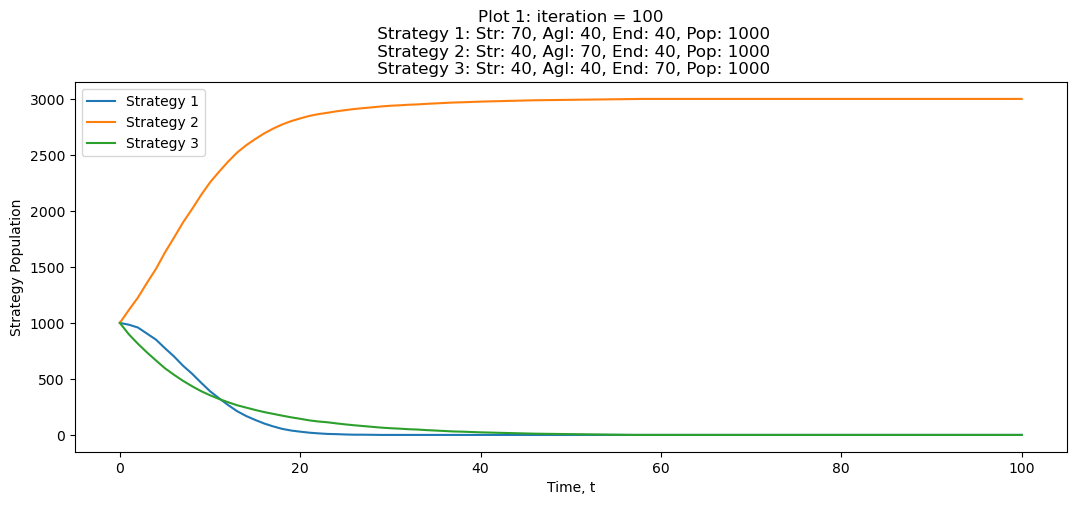

In [5]:
p, t = sim(strategy, iteration)
fig = plt.figure(figsize=(12.8, 4.8))
for i in range(len(p)):
    plt.plot(t, p[i], label=f'Strategy {i+1}')
title = f'Plot 1: iteration = {iteration}'
for i, s in enumerate(strategy): 
    title += f'\n Strategy {i+1}: Str: {s[0]}, Agl: {s[1]}, End: {s[2]}, Pop: {s[3]}'
plt.title(title)
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()
# plt.savefig('Plot 1', bbox_inches='tight')

## Plot 2

In [6]:
initial_population = 1000
            # Strength, Agility, Endurance, Population
strategy = [np.array([70, 40, 40, initial_population]),
            np.array([40, 70, 40, initial_population]),
            np.array([69, 70, 11, initial_population])]
iteration = 300

In [7]:
p, t = sim(strategy, iteration)

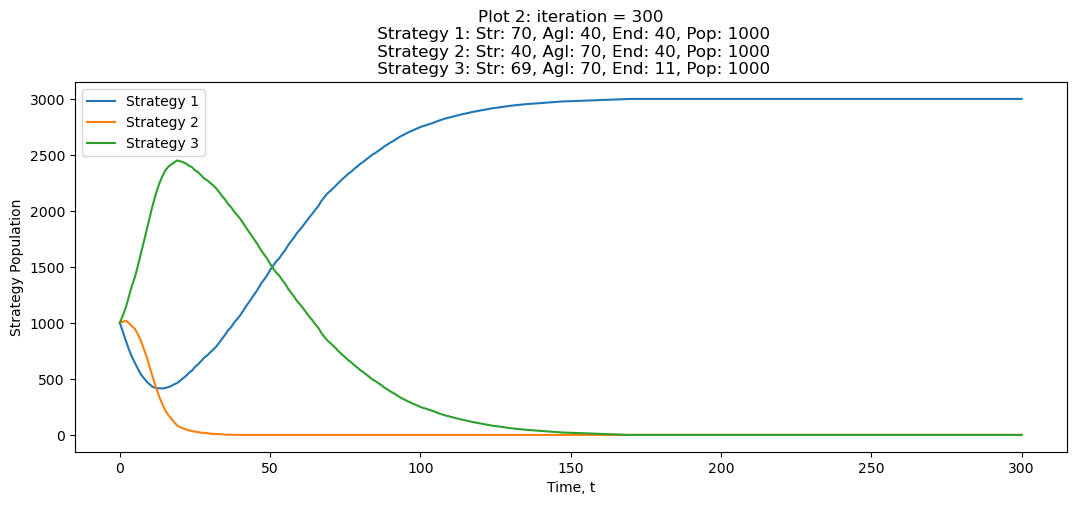

In [8]:
fig = plt.figure(figsize=(12.8, 4.8))
for i in range(len(p)):
    plt.plot(t, p[i], label=f'Strategy {i+1}')
title = f'Plot 2: iteration = {iteration}'
for i, s in enumerate(strategy):
    title += f'\n Strategy {i+1}: Str: {s[0]}, Agl: {s[1]}, End: {s[2]}, Pop: {s[3]}'
plt.title(title)
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()
# plt.savefig('Plot 2', bbox_inches='tight')

In [9]:
P = payoff_matrix(strategy)
clear_dominated(P)

[[0.9, 0.65, 0.65], [1.15, 0.9, 0.4], [0.86, 1.11, 0.61]]

## Plot 3

In [10]:
initial_population = 1000
strategy = [np.array([ 51,  40,  59, initial_population]),
            np.array([ 78,  52,  20, initial_population]),
            np.array([ 50, 100,   0, initial_population]),
            np.array([ 66,  43,  41, initial_population])]
iteration = 300

In [11]:
p, t = sim(strategy, iteration)

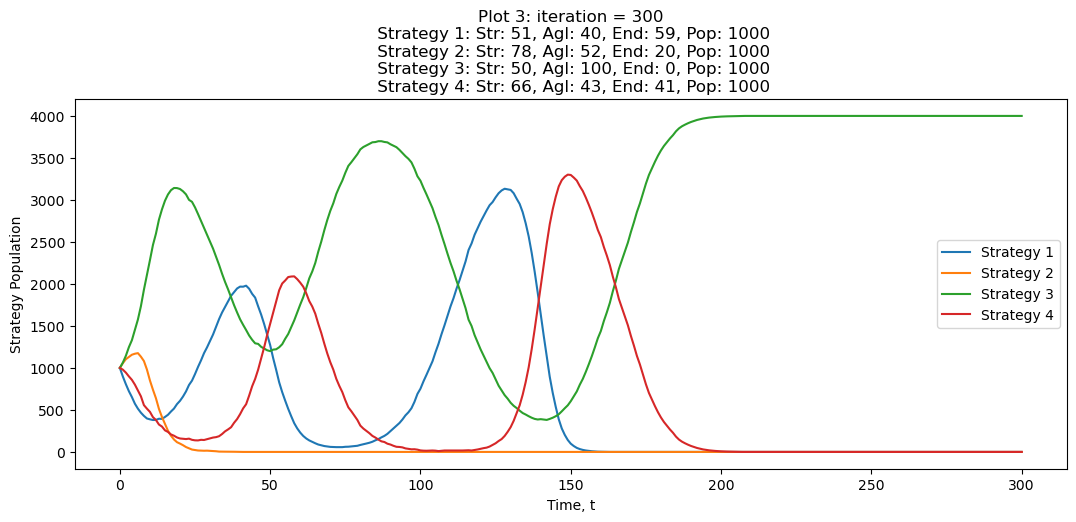

In [12]:
fig = plt.figure(figsize=(12.8, 4.8))
for i in range(len(p)):
    plt.plot(t, p[i], label=f'Strategy {i+1}')
title = f'Plot 3: iteration = {iteration}'
for i, s in enumerate(strategy): 
    title += f'\n Strategy {i+1}: Str: {s[0]}, Agl: {s[1]}, End: {s[2]}, Pop: {s[3]}'
plt.title(title)
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()
# plt.savefig('Plot 3', bbox_inches='tight')

In [13]:
clear_dominated(payoff_matrix(strategy))

[[1.0899999999999999, 0.59, 0.59, 0.59],
 [1.2, 0.7, 0.2769230769230769, 1.2],
 [1.0, 0.9230769230769231, 0.5, 1.0],
 [1.41, 0.41, 0.41, 0.9099999999999999]]

## Plot 4

In [14]:
initial_population = 1000
strategy = [np.array([84, 66, 0, initial_population]),
            np.array([51, 99, 0, initial_population]),
            np.array([50, 50, 50, initial_population])]
iteration = 500

In [15]:
payoff_matrix(strategy)

[[0.5, 0.5, 1.0], [0.5, 0.5, 1.0], [0.5, 0.5, 1.0]]

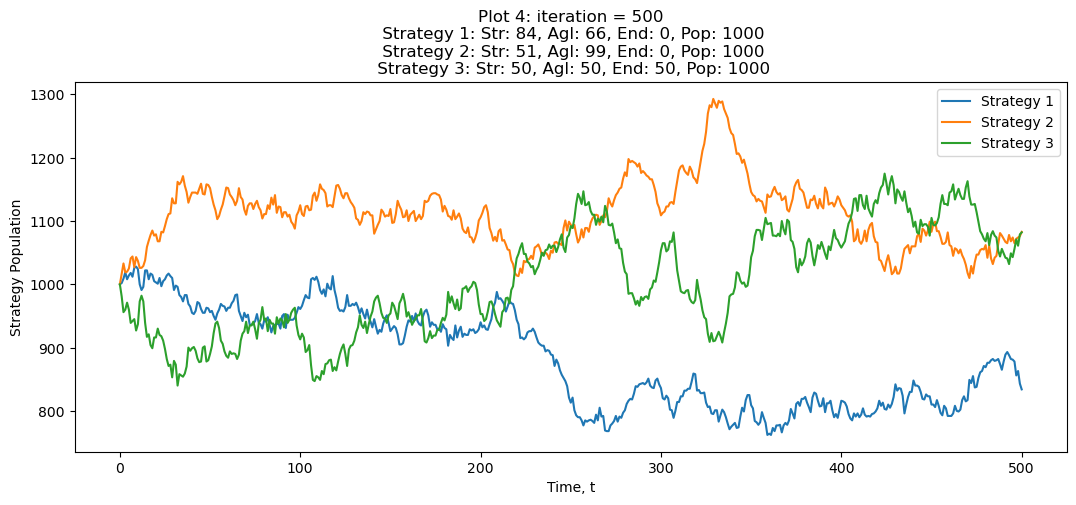

In [16]:
p, t = sim(strategy, iteration)
fig = plt.figure(figsize=(12.8, 4.8))
for i in range(len(p)):
    plt.plot(t, p[i], label=f'Strategy {i+1}')
title = f'Plot 4: iteration = {iteration}'
for i, s in enumerate(strategy): 
    title += f'\n Strategy {i+1}: Str: {s[0]}, Agl: {s[1]}, End: {s[2]}, Pop: {s[3]}'
plt.title(title)
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()
# plt.savefig('Plot 4', bbox_inches='tight')

## Plot 5

In [17]:
initial_population = 1000
strategy = [np.array([70, 40, 40, initial_population]),
            np.array([40, 70, 40, 4]),
            np.array([40, 40, 70, initial_population])]
iteration = 100

In [18]:
payoff_matrix(strategy)

[[0.9, 0.65, 1.4], [1.15, 0.9, 1.275], [0.7, 0.825, 1.2]]

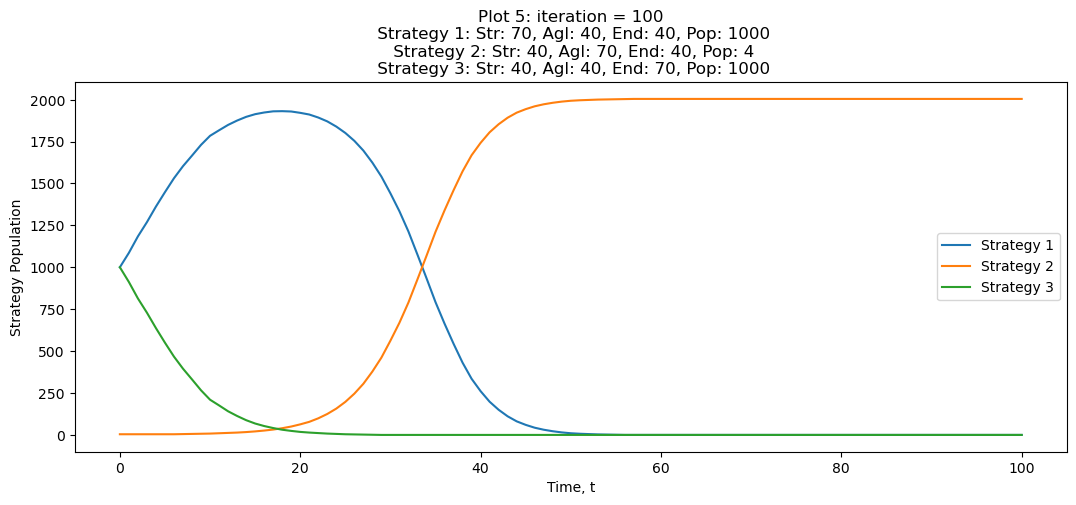

In [19]:
p, t = sim(strategy, iteration)
fig = plt.figure(figsize=(12.8, 4.8))
for i in range(len(p)):
    plt.plot(t, p[i], label=f'Strategy {i+1}')
title = f'Plot 5: iteration = {iteration}'
for i, s in enumerate(strategy): 
    title += f'\n Strategy {i+1}: Str: {s[0]}, Agl: {s[1]}, End: {s[2]}, Pop: {s[3]}'
plt.title(title)
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()
# plt.savefig('Plot 5', bbox_inches='tight')

## Additional Tools (Not part of Assignment, for show purposes only)

In [20]:
# generate random strategy (number of strategy, total stats, population)
number_of_strategies = 5
stat_total = 150
population = 1000
test = generate_random_strategy(number_of_strategies, stat_total, population)
test

[array([  97,   38,   15, 1000]),
 array([  37,   42,   71, 1000]),
 array([  68,   82,    0, 1000]),
 array([  16,   63,   71, 1000]),
 array([  60,   69,   21, 1000])]

In [21]:
iteration = 600
prand, t = sim(test, iteration)

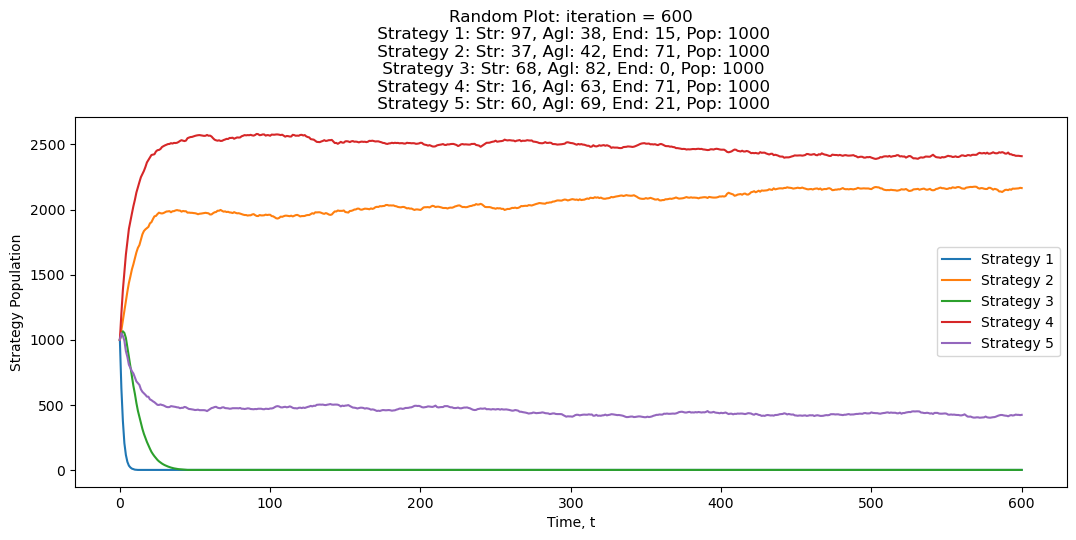

In [22]:
fig = plt.figure(figsize=(12.8, 4.8))
for i in range(len(prand)):
    plt.plot(t, prand[i], label=f'Strategy {i+1}')
title = f'Random Plot: iteration = {iteration}'
for i, s in enumerate(test): 
    title += f'\n Strategy {i+1}: Str: {s[0]}, Agl: {s[1]}, End: {s[2]}, Pop: {s[3]}'
plt.title(title)
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()

In [23]:
# scuffed random mutation
total = []
days = 1
mutation = generate_random_strategy(5, 150, 500)
s,t = sim(mutation, days)
prev = [500] * 5
for k in s:
    total.append(k)
for itr in range(300):
#     print(f"iteration {itr}")
    for i in range(len(s)):
#         print(mutation[i])
        if s[i][-1] < prev[i]:
            mutation[i] = generate_random_strategy(1, min(sum(mutation[i][:3])+1, 300), s[i][-1])[0]
        else:
            mutation[i][3] = s[i][-1]
        prev[i] = s[i][-1]
    s,t = sim(mutation, days)
    for i, k in enumerate(s):
        total[i] += k

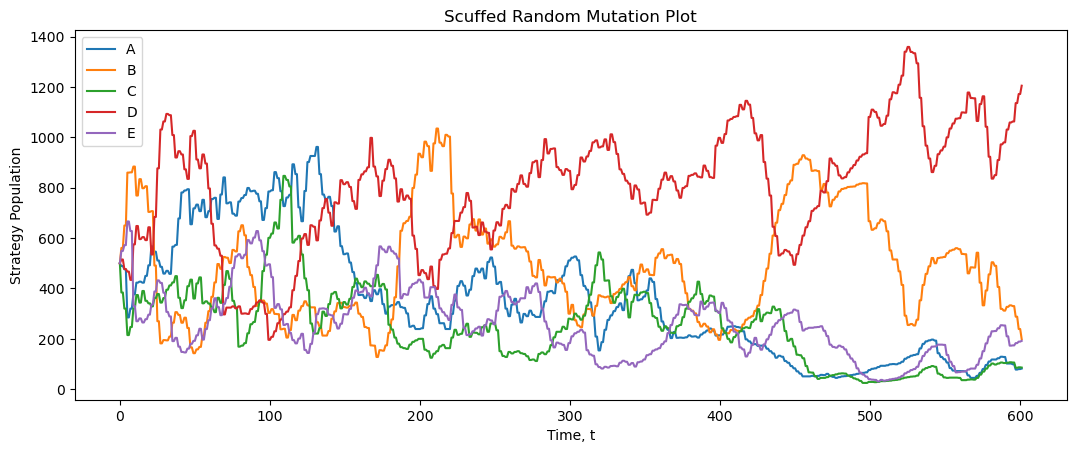

In [24]:
t = list(range(len(total[i])))
plt.figure(figsize=(12.8, 4.8))
plt.title("Scuffed Random Mutation Plot")
for i in range(len(total)):
    plt.plot(t, total[i], label=f'{chr(65+i)}')
plt.xlabel('Time, t')
plt.ylabel('Strategy Population')
plt.legend()

In [25]:
mutation

[array([100,  82, 100,  80]),
 array([ 87, 100, 100, 239]),
 array([100,  96,  85,  87]),
 array([ 100,   83,   99, 1172]),
 array([100,  82, 100, 189])]